Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.1 목표 예측을 위한 회귀분석

### 바로가기

- [1. Housing 데이터 살펴보기](#1.-Housing-데이터-살펴보기)
    - [Housing 데이터셋의 기본 정보]
    - [회귀분석에 사용할 피처 살펴보기]
- [2. 보스턴의 집값 예측하기](#2.-보스턴의-집값-예측하기)
    - [피처들의 단위 맞춰주기 : 피처 스케일링]
    - [변수들의 상관관계 분석]
    - [회귀분석 적용하기]
- [3. 예측 모델을 평가해보자](#3.-예측-모델을-평가해보자)
    - [예측 모델의 평가]
    - [어떤 피처가 가장 유의미한 변수일까]
    - [회귀분석 예측 성능을 높이기 위한 방법 : 다중공선성 확인]
- [4. 분석 결과의 시각화](#4.-분석-결과의-시각화)
    - [지도로 살펴보는 보스턴의 예상 집값]
- [회귀분석으로 흉내내는 부동산 점쟁이](#회귀분석으로-흉내내는-부동산-점쟁이)
- [부록 : 선배의 Summary](#부록-:-선배의-Summary)

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# 1. Housing 데이터 살펴보기

### [Housing 데이터셋의 기본 정보]

###### 데이터 피처 설명
- TOWN : 지역 이름
- LON, LAT : 위도, 경도 정보
- CMEDV : 해당 지역의 집값(중간값)
- CRIM : 지역 범죄율
- ZN : 주택지 비율
- INDUS : 상업적 비즈니스에 활용되지 않는 농지 면적
- CHAS : 경계선에 강에 있는지 여부
- NOX : 산화 질소 농도
- RM : 자택당 평균 방 갯수
- AGE : 1940 년 이전에 건설된 비율
- DIS : 5 개의 보스턴 고용 센터와의 거리에 다른 가중치 부여
- RAD : radial 고속도로와의 접근성 지수
- TAX : 10000달러당 재산세
- PTRATIO : 지역별 학생-교사 비율
- B : 지역의 흑인 지수 (1000(B - 0.63)^2), B는 흑인의 비율.
- LSTAT : 빈곤층의 비율

In [2]:
# Data Source : http://lib.stat.cmu.edu/datasets/boston_corrected.txt

url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/BostonHousing2.csv'
housing = pd.read_csv(url) # read_csv 함수로 데이터를 Dataframe 형태로 불러옵니다.

In [3]:
housing.head()

,TOWN,LON,LAT,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [4]:
print(housing.shape)
print("------------------------------------")
print(housing.info())
print("------------------------------------")
print(housing.columns)

(506, 17)
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 17 columns):
TOWN       506 non-null object
LON        506 non-null float64
LAT        506 non-null float64
CMEDV      506 non-null float64
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13), int64(3), object(1)
memory usage: 67.3+ KB
None
------------------------------------
Index(['TOWN', 'LON', 'LAT', 'CMEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
       'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


-----

###### 예측해야 할 수치인 '집값'에 대한 정보

In [5]:
housing['CMEDV'].describe()

count    506.000000
mean      22.528854
std        9.182176
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: CMEDV, dtype: float64

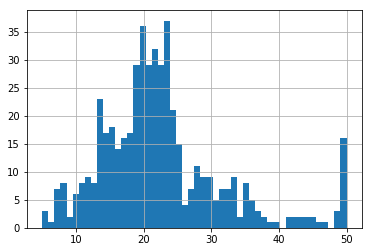

In [6]:
housing['CMEDV'].hist(bins=50) # 보스턴 집값의 분포

-----

### [회귀분석에 사용할 피처 살펴보기]

In [7]:
housing_features_df = housing[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                            'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'CMEDV']]

In [8]:
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    for i in range(len(df.columns)):
        ax = fig.add_subplot(4, 4, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

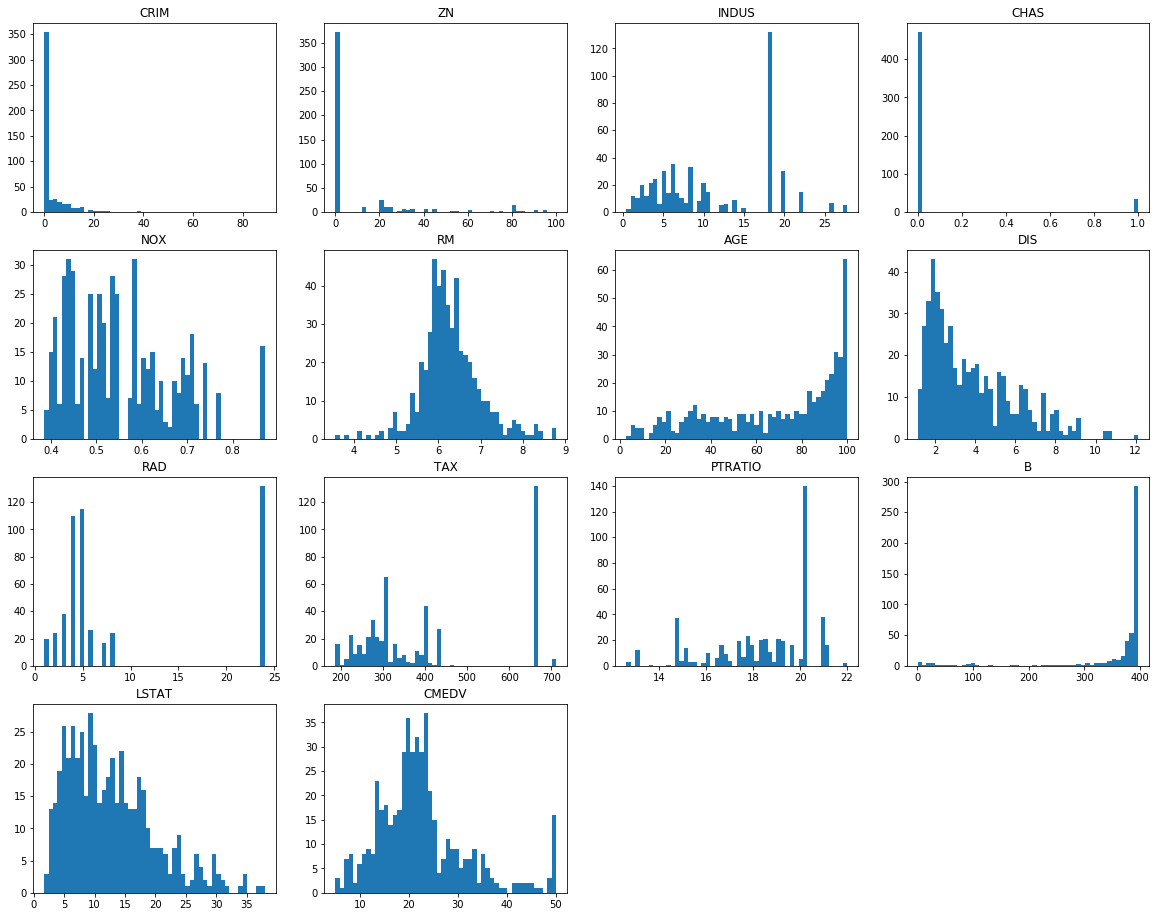

In [9]:
plot_hist_each_column(housing_features_df)

-----

# 2. 보스턴의 집값 예측하기

### [피처들의 단위 맞춰주기 : 피처 스케일링]

In [10]:
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [11]:
scale_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
scaled_housing_df = standard_scaling(housing_features_df, scale_columns)

/anaconda3/envs/gsshop/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
scaled_housing_df = scaled_housing_df.rename(columns={'CMEDV': 'y'})
scaled_housing_df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,-0.419367,0.284548,-1.286636,0,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499,24.0
1,-0.416927,-0.487240,-0.592794,0,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953,21.6
2,-0.416929,-0.487240,-0.592794,0,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,0.396035,-1.207532,34.7
3,-0.416338,-0.487240,-1.305586,0,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,0.415751,-1.360171,33.4
4,-0.412074,-0.487240,-1.305586,0,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,0.440616,-1.025487,36.2
5,-0.416631,-0.487240,-1.305586,0,-0.834458,0.206892,-0.350810,1.076671,-0.752178,-1.105022,0.112920,0.410165,-1.042291,28.7
6,-0.409837,0.048724,-0.476182,0,-0.264892,-0.388027,-0.070159,0.838414,-0.522484,-0.576948,-1.503749,0.426376,-0.031237,22.9
7,-0.403297,0.048724,-0.476182,0,-0.264892,-0.160307,0.977841,1.023625,-0.522484,-0.576948,-1.503749,0.440616,0.909800,22.1
8,-0.395543,0.048724,-0.476182,0,-0.264892,-0.930285,1.116390,1.086122,-0.522484,-0.576948,-1.503749,0.328123,2.419379,16.5
9,-0.400333,0.048724,-0.476182,0,-0.264892,-0.399413,0.615481,1.328320,-0.522484,-0.576948,-1.503749,0.329000,0.622728,18.9


-----

### [변수들의 상관관계 분석]

In [13]:
# 변수간의 상관계수 행렬 구하기
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
corr = scaled_housing_df[cols].corr(method = 'pearson')
print(corr)

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.385064  0.175520 

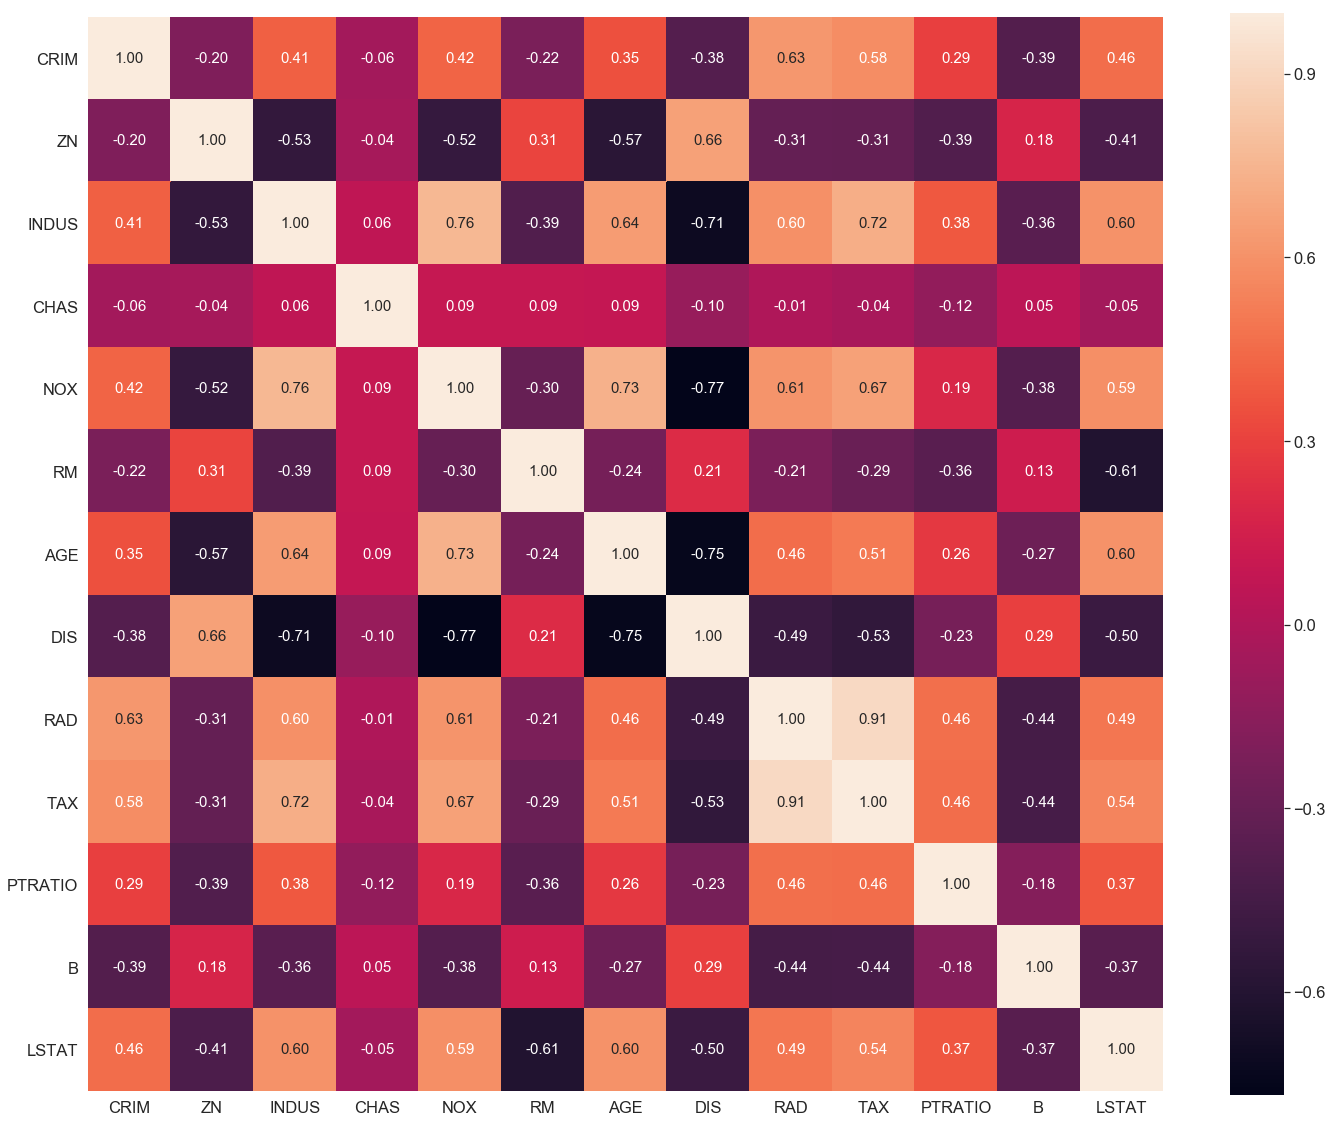

In [14]:
import seaborn as sns

# corr 행렬 히트맵 시각화
cols_view = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols_view,
            xticklabels=cols_view)

plt.tight_layout()
plt.show()

In [15]:
(indus, nox, age) , (rad, tax)

NameError: name 'indus' is not defined

-----

### [회귀분석 적용하기]

In [16]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

X = scaled_housing_df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                       'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = scaled_housing_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train) # 모델 학습

/anaconda3/envs/gsshop/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


-----

# 3. 예측 모델을 평가해보자

### [예측 모델의 평가|]

In [18]:
print(model.score(X_train, y_train)) # train R2 score
print(model.score(X_test, y_test)) # test R2 score

0.734300894109515
0.7687006387041435


In [19]:
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score

y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score

4.754781837986913
4.245819278050094


-----

### [어떤 피처가 가장 유의미한 변수일까]

In [20]:
lr.coef_

array([-0.94282973,  1.06832551,  0.08221866,  2.25402051, -2.14700593,
        3.00439284,  0.20273553, -3.07052456,  2.82734857, -2.01257339,
       -1.9924838 ,  0.94895844, -3.56700165])

[Text(0,0,'CRIM'),
 Text(0,0,'ZN'),
 Text(0,0,'INDUS'),
 Text(0,0,'CHAS'),
 Text(0,0,'NOX'),
 Text(0,0,'RM'),
 Text(0,0,'AGE'),
 Text(0,0,'DIS'),
 Text(0,0,'RAD'),
 Text(0,0,'TAX'),
 Text(0,0,'PTRATIO'),
 Text(0,0,'B'),
 Text(0,0,'LSTAT')]

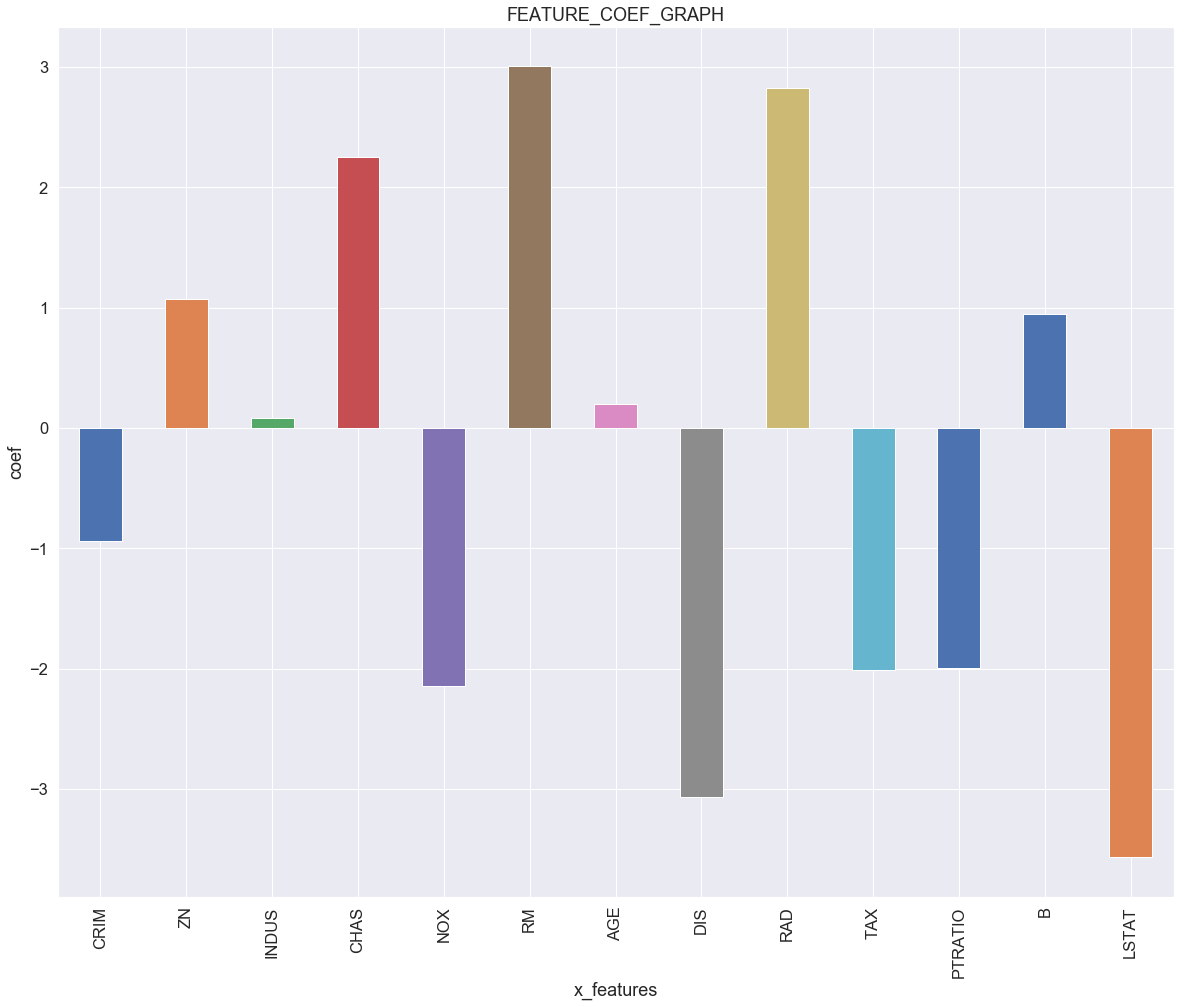

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 16]

coefs = lr.coef_.tolist()
coefs_series = pd.Series(coefs)

x_labels = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

ax = coefs_series.plot(kind='bar')
ax.set_title('FEATURE_COEF_GRAPH')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

In [23]:
!pip install statsmodels
import statsmodels.api as sm

In [26]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
model = sm.OLS(y, X).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     110.2
Date:                Sun, 30 Dec 2018   Prob (F-statistic):          1.83e-136
Time:                        16:38:06   Log-Likelihood:                -1494.2
No. Observations:                 506   AIC:                             3016.
Df Residuals:                     492   BIC:                             3076.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.3427      0.217    102.846      0.000      21.916      22.770
CRIM          -0.9135      0.280     -3.261      0.001      -1.464      -0.363
ZN             1.1130      0.317      3.508      0.000       0.490       1.736
INDUS          0.1595      0.418      0.382      0.703      -0.662       0.981
CHAS           2.6917      0.854      3.152      0.002       1.014       4.369
NOX           -2.0560      0.439     -4.687      0.000      -2.918      -1.194
RM             2.6625      0.291      9.149      0.000       2.091       3.234
AGE            0.0162      0.369      0.044      0.965      -0.708       0.740
DIS           -3.1623      0.416     -7.598      0.000      -3.980      -2.345
RAD            2.6449      0.573      4.620      0.000       1.520       3.770
TAX           -2.1412      0.628     -3.409      0.001      -3.375      -0.907
PTRATIO       -2.0002      0.281     -7.126      0.000      -2.552      -1.449
B              0.8425      0.243      3.467      0.001       0.365       1.320
LSTAT         -3.7895      0.359    -10.558      0.000      -4.495      -3.084
==============================================================================
Omnibus:                      185.097   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              842.380
Skew:                           1.576   Prob(JB):                    1.20e-183
Kurtosis:                       8.479   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----

### [회귀분석 예측 성능을 높이기 위한 방법 : 다중공선성 확인]

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [29]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [30]:
vif.round(1)

,VIF Factor,features
0,1.1,const
1,1.8,CRIM
2,2.3,ZN
3,4.0,INDUS
4,1.1,CHAS
5,4.4,NOX
6,1.9,RM
7,3.1,AGE
8,4.0,DIS
9,7.5,RAD


-----

# 4. 분석 결과의 시각화

### [지도로 살펴보는 보스턴의 예상 집값]

- 시각적인 비교를 위해, 데이터를 나누지 않고 학습한 뒤 실제 y값과 예측된 y값을 모두 하나의 Dataframe으로 병합합니다.

In [36]:
lr = linear_model.LinearRegression()
model = lr.fit(X, y)
y_predictions = lr.predict(X)

housing['y_pred'] = pd.Series(y_predictions)

In [42]:
housing = housing[['TOWN', 'LON', 'LAT', 'CMEDV', 'y_pred']]
housing.head(5)

,TOWN,LON,LAT,CMEDV,y_pred
0,Nahant,-70.955,42.2550,24.0,29.976258
1,Swampscott,-70.950,42.2875,21.6,25.029488
2,Swampscott,-70.936,42.2830,34.7,30.588477
3,Marblehead,-70.928,42.2930,33.4,28.628739
4,Marblehead,-70.922,42.2980,36.2,27.946959


-----

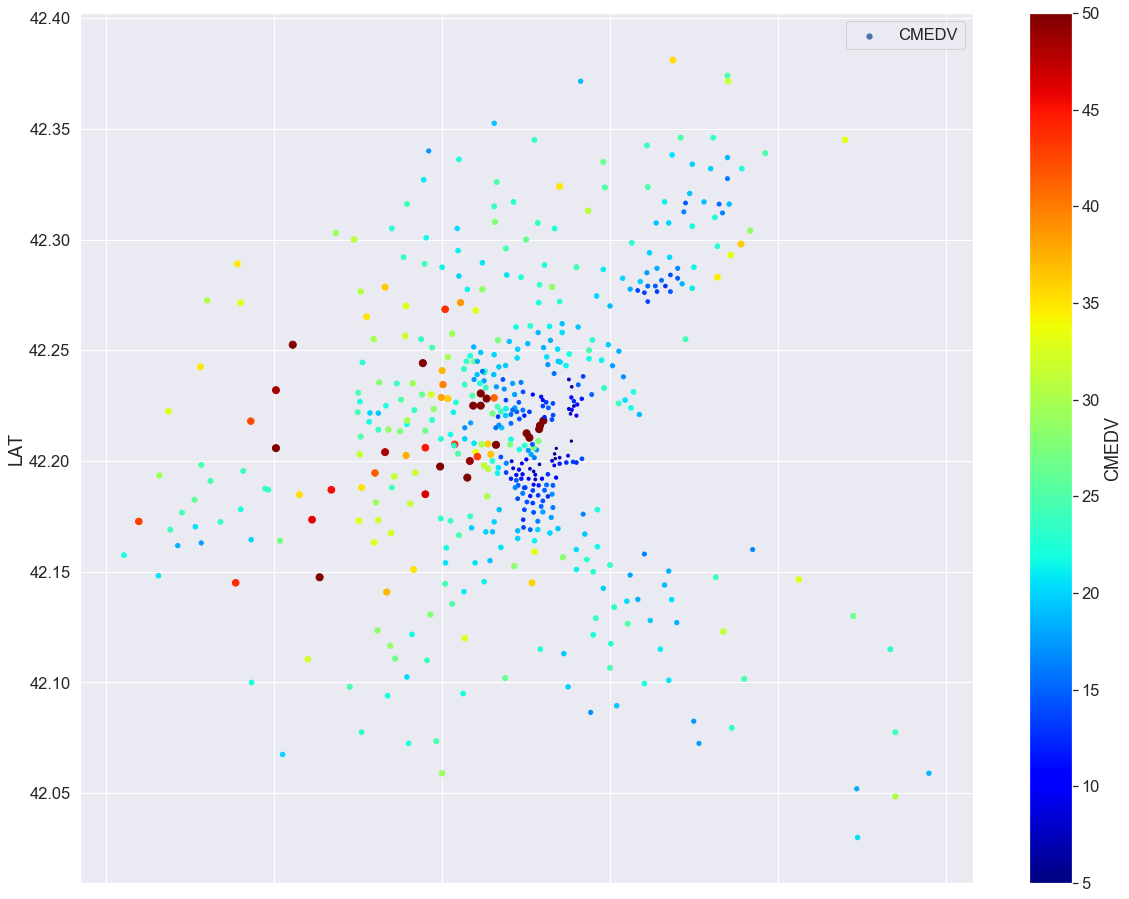

In [53]:
housing.plot(kind="scatter", x="LON", y="LAT",
    s=housing['CMEDV'], label="CMEDV",
    c="CMEDV", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=1.0, figsize=(20,16),
)
plt.legend()

-----

# 회귀분석으로 흉내내는 부동산 점쟁이

-----

# 부록 : 선배의 Summary

In [2]:
이미지

NameError: name '이미지' is not defined